In [61]:
import yfinance as yf
import datetime as dt
import pandas as pd
import vectorbt as vbt

# Set up date range
start = dt.datetime(2019, 1, 1)
end = dt.datetime.now()
symbols = ['SPY', 'DIA', 'QQQ']

# Download data using yfinance
ticker = yf.download(symbols, start=start, end=end)

# Ensure 'Close' prices are extracted
data = ticker['Close']

# --- Ensure all DataFrames have the same index and columns as 'data' (Close prices) ---

# Create 'Year' and 'Quarter' columns for signal generation, based on the original data's index
temp_data_for_signals = pd.DataFrame(index=data.index)
temp_data_for_signals['Year'] = temp_data_for_signals.index.year
temp_data_for_signals['Quarter'] = temp_data_for_signals.index.quarter

# Initialize entry and exit signals DataFrames with the exact same shape as 'data'
entries = pd.DataFrame(False, index=data.index, columns=data.columns)
exits = pd.DataFrame(False, index=data.index, columns=data.columns)

# Define entry and exit points
# Entry: Last trading day of Q2
# Exit: Last trading day of Q4

# Iterate through each symbol to set signals
for symbol in symbols:
    # Identify the last trading day of Q2 and Q4 for each year within the data's range

    # Get last trading day of Q2 for each year
    q2_ends = temp_data_for_signals[temp_data_for_signals['Quarter'] == 2].groupby('Year').tail(1).index

    # Get last trading day of Q4 for each year
    q4_ends = temp_data_for_signals[temp_data_for_signals['Quarter'] == 4].groupby('Year').tail(1).index

    # Set entries (buy signal at end of Q2)
    for date in q2_ends:
        if date in entries.index:
            entries.loc[date, symbol] = True

    # Set exits (sell/short signal at end of Q4)
    for date in q4_ends:
        if date in exits.index:
            exits.loc[date, symbol] = True

# --- Verification Step ---
print("--- Debugging Alignment ---")
print("Price Data Index Length:", len(data.index))
print("Entries Index Length:", len(entries.index))
print("Exits Index Length:", len(exits.index))
print("Are price_data and entries indexes equal?", data.index.equals(entries.index))
print("Are price_data and exits indexes equal?", data.index.equals(exits.index))
print("Are entries and exits indexes equal?", entries.index.equals(exits.columns))

print("Price Data Columns:", data.columns.tolist())
print("Entries Columns:", entries.columns.tolist())
print("Exits Columns:", exits.columns.tolist())
print("Are price_data and entries columns equal?", data.columns.equals(entries.columns))
print("Are price_data and exits columns equal?", data.columns.equals(exits.columns))
print("Are entries and exits columns equal?", entries.columns.equals(exits.columns))
print("---------------------------")


# Backtest the strategy using vectorbt
pf = vbt.Portfolio.from_signals(
    close=data,
    entries=entries,
    exits=exits,
    direction='both',
    freq='D'
)

# Print the portfolio statistics
print("\n--- Portfolio Statistics ---")
print(pf.total_return())
print(pf.stats())


[*********************100%***********************]  3 of 3 completed

--- Debugging Alignment ---
Price Data Index Length: 1611
Entries Index Length: 1611
Exits Index Length: 1611
Are price_data and entries indexes equal? True
Are price_data and exits indexes equal? True
Are entries and exits indexes equal? False
Price Data Columns: ['DIA', 'QQQ', 'SPY']
Entries Columns: ['DIA', 'QQQ', 'SPY']
Exits Columns: ['DIA', 'QQQ', 'SPY']
Are price_data and entries columns equal? True
Are price_data and exits columns equal? True
Are entries and exits columns equal? True
---------------------------

--- Portfolio Statistics ---
Ticker
DIA    0.767676
QQQ   -0.145679
SPY    0.329519
Name: total_return, dtype: float64
Start                         2019-01-02 00:00:00
End                           2025-05-29 00:00:00
Period                         1611 days 00:00:00
Start Value                                 100.0
End Value                              131.717195
Total Return [%]                        31.717195
Benchmark Return [%]                   171.130329
Max G


C:\Users\henry\AppData\Local\Temp\ipykernel_30140\1674584565.py:82: UserWarning:

Object has multiple columns. Aggregating using <function mean at 0x000001B0F1BC5580>. Pass column to select a single column/group.



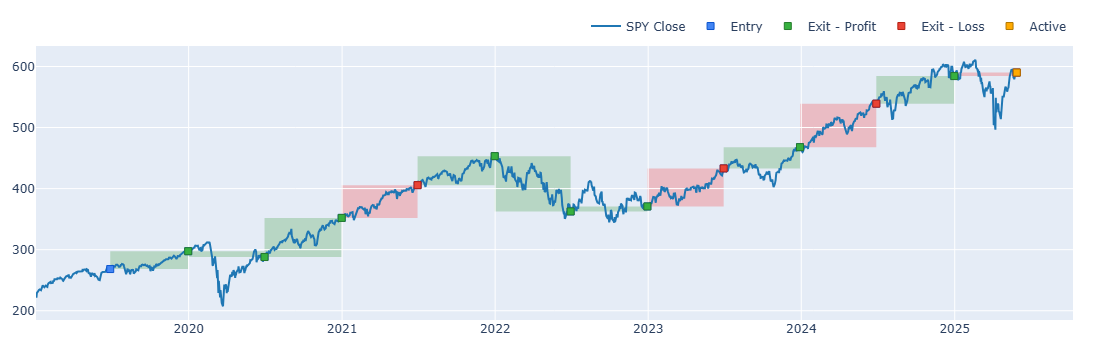

In [62]:
fig = data['SPY'].vbt.plot(trace_kwargs=dict(name='SPY Close'))

# 2. Pass this figure object to the pf.positions.plot() method for SPY
# Ensure you select 'SPY' from pf.positions as well
pf.positions['SPY'].plot(close_trace_kwargs=dict(visible=False), fig=fig).show()

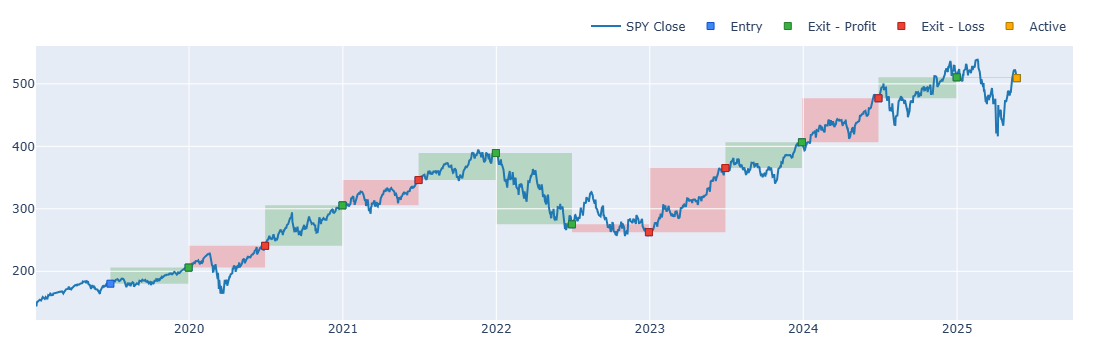

In [59]:
fig = data['QQQ'].vbt.plot(trace_kwargs=dict(name='SPY Close'))

pf.positions['QQQ'].plot(close_trace_kwargs=dict(visible=False), fig=fig).show()

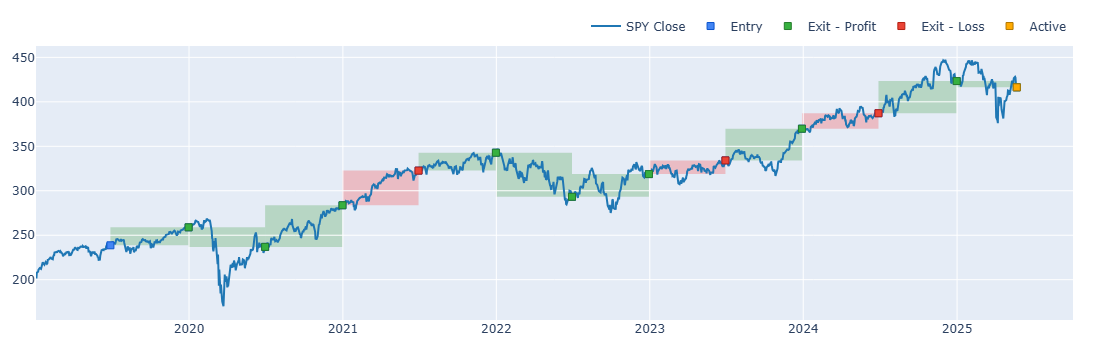

In [60]:
fig = data['DIA'].vbt.plot(trace_kwargs=dict(name='SPY Close'))

pf.positions['DIA'].plot(close_trace_kwargs=dict(visible=False), fig=fig).show()

In [51]:
# --- Calculate Quarterly Returns ---

# Add 'Year' and 'Quarter' columns to the data DataFrame directly for easier grouping
data_with_quarters = data.copy() # Work on a copy to avoid modifying original 'data' prematurely
data_with_quarters['Year'] = data_with_quarters.index.year
data_with_quarters['Quarter'] = data_with_quarters.index.quarter

# Initialize an empty DataFrame to store quarterly returns
all_quarterly_returns = pd.DataFrame()

for symbol in symbols:
    # Filter data for the current symbol
    symbol_data = data_with_quarters[[symbol, 'Year', 'Quarter']]

    # Group by Year and Quarter and get the first and last price for each quarter
    quarter_start_end_prices = symbol_data.groupby(['Year', 'Quarter']).agg(
        first_price=(symbol, 'first'),
        last_price=(symbol, 'last')
    )

    # Calculate quarterly return for the current symbol
    # Ensure there's a last price for the quarter (i.e., not an incomplete quarter)
    quarter_start_end_prices[f'{symbol}_Quarterly_Return'] = (
        (quarter_start_end_prices['last_price'] - quarter_start_end_prices['first_price']) /
        quarter_start_end_prices['first_price']
    )

    # Extract only the quarterly returns and append to the main DataFrame
    if all_quarterly_returns.empty:
        all_quarterly_returns = quarter_start_end_prices[[f'{symbol}_Quarterly_Return']]
    else:
        all_quarterly_returns = all_quarterly_returns.join(quarter_start_end_prices[[f'{symbol}_Quarterly_Return']])

# Rename columns for clarity (remove the '_Quarterly_Return' suffix for direct symbol access)
all_quarterly_returns.columns = symbols

# Now, group by the Quarter level (second level of the MultiIndex) to get average across years
average_quarterly_returns = all_quarterly_returns.groupby(level='Quarter').mean()

# Identify the best and worst performing quarters
print("\n--- Average Quarterly Returns for Each Symbol ---")
print(average_quarterly_returns)

print("\n--- Best Performing Quarter (Average Return) ---")
best_quarter = average_quarterly_returns.idxmax()
best_return = average_quarterly_returns.max()
for symbol in symbols:
    # Access the scalar value using .item() or just by directly indexing if it's already a scalar
    # Since best_quarter[symbol] and best_return[symbol] are Series containing one value, .item() extracts it
    print(f"{symbol}: Q{best_quarter[symbol].item()} with average return of {best_return[symbol].item():.2%}")

print("\n--- Worst Performing Quarter (Average Return) ---")
worst_quarter = average_quarterly_returns.idxmin()
worst_return = average_quarterly_returns.min()
for symbol in symbols:
    print(f"{symbol}: Q{worst_quarter[symbol].item()} with average return of {worst_return[symbol].item():.2%}")



--- Average Quarterly Returns for Each Symbol ---
              SPY       DIA       QQQ
Quarter                              
1        0.015376 -0.000841  0.031658
2        0.051069  0.029502  0.081310
3        0.009019  0.011483  0.008603
4        0.085600  0.087269  0.088932

--- Best Performing Quarter (Average Return) ---
SPY: Q4 with average return of 8.56%
DIA: Q4 with average return of 8.73%
QQQ: Q4 with average return of 8.89%

--- Worst Performing Quarter (Average Return) ---
SPY: Q3 with average return of 0.90%
DIA: Q1 with average return of -0.08%
QQQ: Q3 with average return of 0.86%
